In [1]:
import pandas as pd
import numpy as np
import os
from wwo_hist import retrieve_hist_data


# univariate multi-step encoder-decoder convlstm
from math import sqrt
from numpy import split
from numpy import array
from pandas import read_csv
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import LSTM
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers import ConvLSTM2D

from numpy.fft import fft, ifft
import math
import datetime as dt
from datetime import timedelta

In [2]:
dataset = pd.read_csv('household_power_consumption.csv', sep = ';', low_memory=False, infer_datetime_format=True, parse_dates={'datetime':[0,1]}, index_col=['datetime'])


In [3]:
dataset

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
2006-12-16 17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2006-12-16 17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
2006-12-16 17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
2006-12-16 17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0
...,...,...,...,...,...,...,...
2010-11-26 20:58:00,0.946,0.000,240.430,4.000,0.000,0.000,0.0
2010-11-26 20:59:00,0.944,0.000,240.000,4.000,0.000,0.000,0.0
2010-11-26 21:00:00,0.938,0.000,239.820,3.800,0.000,0.000,0.0


## Data Reading and Cleaning

In [4]:
# Energy Consumption Data

#Read Dataset
dataset = pd.read_csv('household_power_consumption.csv', sep = ';', low_memory=False, infer_datetime_format=True, parse_dates={'datetime':[0,1]}, index_col=['datetime'])

# fill missing values with a value at the same time one day ago

# mark all missing values
dataset.replace('?', None, inplace=True)
# make dataset numeric
dataset = dataset.astype('float32')

# fill missing values with a value at the same time one day ago
def fill_missing(values):
	one_day = 60 * 24
	for row in range(values.shape[0]):
		for col in range(values.shape[1]):
			if np.isnan(values[row, col]):
				values[row, col] = values[row - one_day, col]

fill_missing(dataset.values)

#Transform Global_active_power to Kwh
dataset['Global_active_power'] = (dataset['Global_active_power'])
dataset['Sub_metering_1'] = (dataset['Sub_metering_1']* 60 / 1000)
dataset['Sub_metering_2'] = (dataset['Sub_metering_2']* 60 / 1000)
dataset['Sub_metering_3'] = (dataset['Sub_metering_3']* 60 / 1000)
dataset = dataset[['Global_active_power','Sub_metering_1','Sub_metering_2','Sub_metering_3']]

#Resample dataset to 60min energy consumption

dataset_hour = dataset.resample('60min').mean()

In [5]:
 # Weather data

frequency = 1
start_date = '01-AUG-2008'
end_date = '01-AUG-2010'
api_key = '9dc727c254e4416799b103813222005'
location_list = ['sceaux']
hist_weather_data = retrieve_hist_data(api_key,
                                location_list,
                                start_date,
                                end_date,
                                frequency,
                                location_label = False,
                                export_csv = True,
                                store_df = True)

df_weather = pd.read_csv('sceaux.csv')
df_weather['date_time'] = pd.to_datetime(df_weather['date_time'])
df_weather.set_index('date_time', inplace = True)
df_weather = df_weather.loc[:,['tempC','humidity','windspeedKmph']]



Retrieving weather data for sceaux




c:\Users\agottanil\AppData\Local\Programs\Python\Python310\lib\site-packages\wwo_hist\__init__.py:69: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  list_mon_begin = pd.date_range(start_date, end_date, freq='MS', closed='right')
c:\Users\agottanil\AppData\Local\Programs\Python\Python310\lib\site-packages\wwo_hist\__init__.py:74: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  list_mon_end = pd.date_range(start_date, end_date, freq='M', closed='left')


Currently retrieving data for sceaux: from 2008-08-01 to 2008-08-31
Time elapsed (hh:mm:ss.ms) 0:00:01.813284
Currently retrieving data for sceaux: from 2008-09-01 to 2008-09-30
Time elapsed (hh:mm:ss.ms) 0:00:02.907254
Currently retrieving data for sceaux: from 2008-10-01 to 2008-10-31
Time elapsed (hh:mm:ss.ms) 0:00:03.908230
Currently retrieving data for sceaux: from 2008-11-01 to 2008-11-30
Time elapsed (hh:mm:ss.ms) 0:00:04.876558
Currently retrieving data for sceaux: from 2008-12-01 to 2008-12-31
Time elapsed (hh:mm:ss.ms) 0:00:05.815867
Currently retrieving data for sceaux: from 2009-01-01 to 2009-01-31
Time elapsed (hh:mm:ss.ms) 0:00:06.882224
Currently retrieving data for sceaux: from 2009-02-01 to 2009-02-28
Time elapsed (hh:mm:ss.ms) 0:00:07.761993
Currently retrieving data for sceaux: from 2009-03-01 to 2009-03-31
Time elapsed (hh:mm:ss.ms) 0:00:08.780962
Currently retrieving data for sceaux: from 2009-04-01 to 2009-04-30
Time elapsed (hh:mm:ss.ms) 0:00:09.799518
Currently 

In [6]:
#Filter dataset datetime to index from weather dataset

dataset_all_hour = dataset_hour[(dataset_hour.index >= (df_weather.index.min() - timedelta(hours=1))) & (dataset_hour.index <= (df_weather.index.max()- timedelta(hours=1)))]

#Concat Dataset

dataset_all_hour = pd.concat([dataset_all_hour.reset_index(),df_weather.reset_index()], axis = 1).set_index('datetime').loc[:,['Global_active_power','Sub_metering_1','Sub_metering_2','Sub_metering_3','tempC','humidity','windspeedKmph']]

#Insert weekday binary

dataset_all_hour['weekday'] = (pd.to_datetime(dataset_all_hour.reset_index()['datetime'] + timedelta(hours=1)).dt.weekday.values) >= 5
dataset_all_hour['weekday'] = np.where(dataset_all_hour['weekday'].values == False,0,1)

#Insert time 
dataset_all_hour['time'] = pd.to_datetime(dataset_all_hour.reset_index()['datetime'] + timedelta(hours=1)).dt.hour.values

dataset_all_hour.to_csv('dataset_final.csv')

In [7]:
dataset = pd.read_csv('dataset_final.csv', infer_datetime_format=True, parse_dates=['datetime'], index_col=['datetime'])

# Dataset Min

In [5]:
# Energy Consumption Data

#Read Dataset
dataset = pd.read_csv('household_power_consumption.csv', sep = ';', low_memory=False, infer_datetime_format=True, parse_dates={'datetime':[0,1]}, index_col=['datetime'])

# fill missing values with a value at the same time one day ago

# mark all missing values
dataset.replace('?', None, inplace=True)
# make dataset numeric
dataset = dataset.astype('float32')

# fill missing values with a value at the same time one day ago
def fill_missing(values):
	one_day = 60 * 24
	for row in range(values.shape[0]):
		for col in range(values.shape[1]):
			if np.isnan(values[row, col]):
				values[row, col] = values[row - one_day, col]

fill_missing(dataset.values)

#Transform Global_active_power to Kwh
dataset['Global_active_power'] = (dataset['Global_active_power'])
dataset['Sub_metering_1'] = (dataset['Sub_metering_1']* 60 / 1000)
dataset['Sub_metering_2'] = (dataset['Sub_metering_2']* 60 / 1000)
dataset['Sub_metering_3'] = (dataset['Sub_metering_3']* 60 / 1000)
dataset = dataset[['Global_active_power','Sub_metering_1','Sub_metering_2','Sub_metering_3']]

#Resample dataset to 60min energy consumption

dataset_min = dataset

In [16]:
df_weather_min = df_weather.resample('min').ffill()

In [18]:
#Filter dataset datetime to index from weather dataset

dataset_all_min = dataset_min[(dataset_min.index >= (df_weather_min.index.min() - timedelta(minutes=1))) & (dataset_min.index <= (df_weather_min.index.max()- timedelta(minutes=1)))]

#Concat Dataset

dataset_all_min = pd.concat([dataset_all_min.reset_index(),df_weather_min.reset_index()], axis = 1).set_index('datetime').loc[:,['Global_active_power','Sub_metering_1','Sub_metering_2','Sub_metering_3','tempC','humidity','windspeedKmph']]

#Insert weekday binary

dataset_all_min['weekday'] = (pd.to_datetime(dataset_all_min.reset_index()['datetime'] + timedelta(minutes=1)).dt.weekday.values) >= 5
dataset_all_min['weekday'] = np.where(dataset_all_min['weekday'].values == False,0,1)

#Insert time 
dataset_all_min['time'] = pd.to_datetime(dataset_all_min.reset_index()['datetime'] + timedelta(minutes=1)).dt.hour.values

dataset_all_min.to_csv('dataset_final_min.csv')

In [19]:
dataset_all_min

,Global_active_power,Sub_metering_1,Sub_metering_2,Sub_metering_3,tempC,humidity,windspeedKmph,weekday,time
datetime,,,,,,,,,
2008-07-31 23:59:00,0.498,0.0,0.00,0.00,20,90,13,0,0
2008-08-01 00:00:00,0.500,0.0,0.00,0.06,20,90,13,0,0
2008-08-01 00:01:00,0.482,0.0,0.00,0.06,20,90,13,0,0
2008-08-01 00:02:00,0.502,0.0,0.00,0.00,20,90,13,0,0
2008-08-01 00:03:00,0.556,0.0,0.00,0.06,20,90,13,0,0
...,...,...,...,...,...,...,...,...,...
2010-08-01 22:55:00,0.592,0.0,0.06,0.42,16,88,6,1,22
2010-08-01 22:56:00,0.232,0.0,0.06,0.06,16,88,6,1,22
2010-08-01 22:57:00,0.232,0.0,0.06,0.06,16,88,6,1,22


# Exploratory Analysis

In [15]:
dataset

,Global_active_power,Sub_metering_1,Sub_metering_2,Sub_metering_3,tempC,humidity,windspeedKmph,weekday,time
datetime,,,,,,,,,
2008-07-31 23:00:00,113.584000,0.0,35.28,9.30,20,90,13,0,0
2008-08-01 00:00:00,27.620000,0.0,4.32,6.78,19,90,14,0,1
2008-08-01 01:00:00,24.358000,0.0,2.58,6.90,18,89,15,0,2
2008-08-01 02:00:00,23.444000,0.0,1.80,7.08,17,89,15,0,3
2008-08-01 03:00:00,21.686000,0.0,1.38,6.96,17,87,14,0,4
...,...,...,...,...,...,...,...,...,...
2010-08-01 18:00:00,18.194000,0.0,1.14,6.12,20,66,6,1,19
2010-08-01 19:00:00,18.730000,0.0,1.80,5.94,18,76,6,1,20
2010-08-01 20:00:00,19.702000,0.0,1.32,6.18,16,85,7,1,21


In [16]:
dataset.describe()

,Global_active_power,Sub_metering_1,Sub_metering_2,Sub_metering_3,tempC,humidity,windspeedKmph,weekday,time
count,17544.000000,17544.000000,17544.000000,17544.000000,17544.000000,17544.000000,17544.000000,17544.000000,17544.000000
mean,64.163959,3.798529,4.002688,24.593362,11.034827,79.201664,12.273313,0.287278,11.500000
std,50.617830,12.376925,13.355897,26.761620,7.592669,15.092341,6.387443,0.452505,6.922384
min,7.440000,0.000000,0.000000,0.000000,-9.000000,27.000000,0.000000,0.000000,0.000000
25%,21.403500,0.000000,0.000000,2.520000,6.000000,70.000000,8.000000,0.000000,5.750000
50%,48.254000,0.000000,1.230000,6.120000,11.000000,83.000000,11.000000,0.000000,11.500000
75%,93.138000,0.000000,2.220000,54.180000,16.000000,92.000000,16.000000,1.000000,17.250000
max,393.632000,172.740000,158.160000,75.060000,35.000000,100.000000,63.000000,1.000000,23.000000


In [13]:
dataset.isna().sum()

Global_active_power    0
tempC                  0
humidity               0
windspeedKmph          0
weekday                0
time                   0
dtype: int64

In [21]:
dataset.index.min()

'2008-08-01 00:00:00'

In [22]:
dataset.index.max()

'2010-08-01 23:00:00'

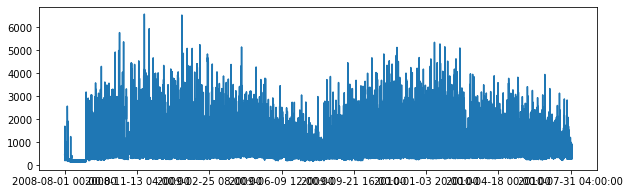

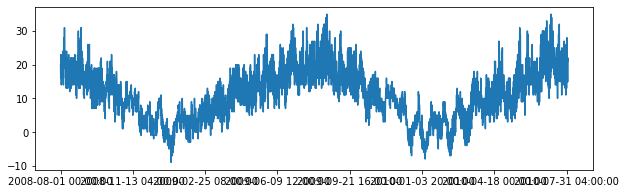

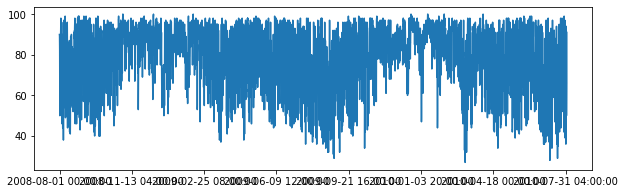

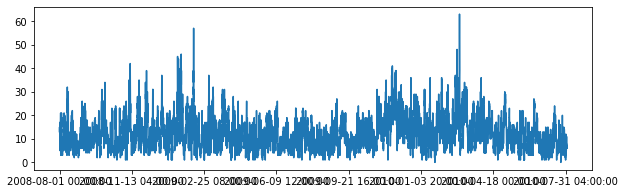

In [23]:
dataset['Global_active_power'].plot(figsize=(10, 3))
plt.show()

dataset['tempC'].plot(figsize=(10, 3))
plt.show()

dataset['humidity'].plot(figsize=(10, 3))
plt.show()

dataset['windspeedKmph'].plot(figsize=(10,3))
plt.show()